<a href="https://colab.research.google.com/github/V-Sekai-fire/meshgpt-dataset-01/blob/main/MeshGPT_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from re import T
is_train_autoencoder = False
is_train_autoencoder_iteration = True
is_train_mesh_transformer = False
is_train_mesh_transformer_iteration = True
is_clear_dataset_npz = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!yes | pip uninstall typing-extensions
!yes | pip install git+https://github.com/MarcusLoppe/classifier-free-guidance-pytorch.git
!yes | pip install -q git+https://github.com/MarcusLoppe/meshgpt-pytorch.git
!yes | pip install trimesh

Found existing installation: typing_extensions 4.9.0
Uninstalling typing_extensions-4.9.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/typing_extensions-4.9.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/typing_extensions.py
Proceed (Y/n)?   Successfully uninstalled typing_extensions-4.9.0
  Cloning https://github.com/MarcusLoppe/classifier-free-guidance-pytorch.git to /tmp/pip-req-build-mhhikok4
  Running command git clone --filter=blob:none --quiet https://github.com/MarcusLoppe/classifier-free-guidance-pytorch.git /tmp/pip-req-build-mhhikok4
  Resolved https://github.com/MarcusLoppe/classifier-free-guidance-pytorch.git to commit 5c189f32dbc20cd5882be4ef2a132e2aabcb8df5
  Preparing metadata (setup.py) ... done
  Using cached typing_extensions-4.9.0-py3-none-any.whl (32 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-p

In [ ]:
import torch
import trimesh
import numpy as np
import os
import csv
from collections import OrderedDict

from meshgpt_pytorch import (
    MeshTransformerTrainer,
    MeshAutoencoderTrainer,
    MeshAutoencoder,
    MeshTransformer
)
from meshgpt_pytorch.data import (
    derive_face_edges_from_faces
)

In [ ]:
import trimesh
import torch
import numpy as np
import os
from collections import OrderedDict

max_faces = 5000

def get_mesh(file_path):
    mesh = trimesh.load(file_path, force='mesh')

    # Center and scale vertices
    center = np.mean(mesh.vertices, axis=0)
    vertices = mesh.vertices - center
    max_abs = np.max(np.abs(vertices))
    scale_factor = (1 / 128) / max_abs
    vertices *= scale_factor

    # Quantize vertices
    vertices = np.around(vertices).astype(np.float32)

    # Sort vertices by Z, Y, X
    sorted_indices = np.lexsort(vertices.T[::-1])
    vertices = vertices[sorted_indices]

    # Map old indices to new, sorted indices
    vertex_map = np.empty(len(sorted_indices), dtype=int)
    vertex_map[sorted_indices] = np.arange(len(sorted_indices))

    # Reindex faces
    reindexed_faces = vertex_map[mesh.faces]
    sorted_faces = np.sort(reindexed_faces, axis=1)

    return vertices, sorted_faces

def augment_mesh(vertices, jitter_strength=0.01):
    jitter_amount = np.random.uniform(-jitter_strength, jitter_strength, size=vertices.shape)
    vertices += jitter_amount
    return vertices

def snake_to_sentence_case(snake_str):
    components = snake_str.split("_")
    return " ".join(word.capitalize() for word in components)


# !yes | pip install replicate

# import asyncio
# import replicate

# image = open("mystery.jpg", "rb")
# async def vertices_faces_image_prompt_as_json_dictionary():
#     image = open("mystery.jpg", "rb")
#     output = await replicate.run(
#         "nateraw/video-llava:a494250c04691c458f57f2f8ef5785f25bc851e0c91fd349995081d4362322dd",
#         input={
#             "text_prompt": "Describe focus of the image as a json dictionary.",
#             "image_path": image,
#         }
#     )
#     return output
# asyncio.run(run_model())

# https://huggingface.co/TheBloke/Nous-Hermes-2-SOLAR-10.7B-GGUF/blob/main/nous-hermes-2-solar-10.7b.Q6_K.gguf
# !yes | pip install llama_cpp
# from llama_cpp import Llama
# llm = Llama(model_path="path/to/llama-2/llama-model.gguf", chat_format="chatml")
# llm.create_chat_completion(
#       messages = [
#           {"role": "system", "content": "You are an assistant who perfectly describes images."},
#           {
#               "role": "user",
#               "content": "Describe this image in detail please."
#           }
#       ]
# )

def load_filename(directory, variations):
    obj_datas = []

    # Get random scale factors within a range
    scale_factors = np.random.uniform(0.75, 1.0, size=variations)

    for filename in os.listdir(directory):
        if filename.endswith(".glb"):
            file_path = os.path.join(directory, filename)
            vertices, faces = get_mesh(file_path)

            if len(faces) > max_faces:
                print(f"Mesh {filename} has {len(faces)} faces which is more than the allowed {max_faces} faces. Rejecting.")
                continue

            faces_tensor = torch.tensor(faces, dtype=torch.long).to("cuda")
            face_edges = derive_face_edges_from_faces(faces_tensor)

            texts, _ = os.path.splitext(filename)
            texts = snake_to_sentence_case(texts)
            # Run video llava on the image. "Describe the focus of the photo as a json dictionary."
            for scale_factor in scale_factors:
                aug_vertices = augment_mesh(vertices.copy()) * scale_factor
                aug_vertices_tensor = torch.tensor(aug_vertices, dtype=torch.float)

                obj_data = {
                    "vertices": aug_vertices_tensor.to("cuda"),
                    "faces": faces_tensor,
                    "face_edges": face_edges,
                    "texts": texts
                }
                obj_datas.append(obj_data)

    print(f"[create_mesh_dataset] Returning {len(obj_datas)} meshes")
    return obj_datas


In [ ]:
from pathlib import Path
import gc
import torch
import os
from meshgpt_pytorch import MeshDataset

torch.cuda.empty_cache()
gc.collect()


project_name = "demo_mesh"

working_dir = f'/content/drive/MyDrive/{project_name}'

working_dir = Path(working_dir)
working_dir.mkdir(exist_ok = True, parents = True)
dataset_path = working_dir / (project_name + ".npz")


if is_clear_dataset_npz:
    data = load_filename(working_dir, 1)
    dataset = MeshDataset(data)
    dataset.generate_face_edges()
    dataset.save(dataset_path)
else:
    dataset = MeshDataset.load(dataset_path)

print(dataset.data[0].keys())
print(set(item["texts"] for item in dataset.data)  )


Mesh sk_masculine_teen.glb has 13408 faces which is more than the allowed 5000 faces. Rejecting.
Mesh sk_masculine_adult_ik.glb has 13410 faces which is more than the allowed 5000 faces. Rejecting.
Mesh sk_baby_01.glb has 13408 faces which is more than the allowed 5000 faces. Rejecting.
Mesh sk_masculine_adult.glb has 13410 faces which is more than the allowed 5000 faces. Rejecting.
Mesh sk_feminine_teen.glb has 13358 faces which is more than the allowed 5000 faces. Rejecting.
Mesh s_vehicle_bicycle_bmx.glb has 39972 faces which is more than the allowed 5000 faces. Rejecting.
Mesh s_table_coffee_variation.glb has 8140 faces which is more than the allowed 5000 faces. Rejecting.
Mesh s_chair_office_01.glb has 25192 faces which is more than the allowed 5000 faces. Rejecting.
Mesh s_sgcontroller.glb has 8848 faces which is more than the allowed 5000 faces. Rejecting.
Mesh sk_feminine_adult.glb has 13358 faces which is more than the allowed 5000 faces. Rejecting.
Mesh sk_child_01.glb has 13

### Inspect

In [ ]:
seen_texts = []  # Keep track of seen texts to avoid processing duplicates
mesh_list = []  # List to store individual meshes
translation_distance = 1.0  # Distance to translate vertices, set to 1 unit as required

# Iterate over each item in the dataset
for r, item in enumerate(dataset.data):
    texts = item['texts']

    # Skip this iteration if there are no texts or if we've already seen these texts
    if len(texts) == 0 or texts in seen_texts:
        continue

    # Add these texts to the list of seen texts
    seen_texts.append(texts)

    # Get vertices and faces
    vertices = np.array(item['vertices'].cpu())
    faces = np.array(item['faces'].cpu())

    # Translate the vertices copy
    translation_vector = np.array([len(seen_texts) * translation_distance, 0, 0])  # Translation along the x-axis
    vertices[:, :3] += translation_vector  # Apply translation only to x, y, z

    # Create a new mesh object with the translated vertices and original faces
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

    # Append the new mesh to our list of meshes
    mesh_list.append(mesh)

    print(f"Iteration {r} complete. Processed {len(vertices)} vertices and {len(faces)} faces.")

# After iterating over all items, print the number of processed meshes
print(f"Total number of processed meshes: {len(mesh_list)}")


Iteration 0 complete. Processed 403 vertices and 480 faces.
Iteration 1 complete. Processed 403 vertices and 480 faces.
Iteration 2 complete. Processed 336 vertices and 168 faces.
Iteration 3 complete. Processed 264 vertices and 335 faces.
Iteration 4 complete. Processed 168 vertices and 144 faces.
Iteration 5 complete. Processed 168 vertices and 144 faces.
Iteration 6 complete. Processed 205 vertices and 320 faces.
Iteration 7 complete. Processed 216 vertices and 108 faces.
Iteration 8 complete. Processed 128 vertices and 256 faces.
Iteration 9 complete. Processed 96 vertices and 48 faces.
Iteration 10 complete. Processed 96 vertices and 48 faces.
Iteration 11 complete. Processed 62 vertices and 48 faces.
Iteration 12 complete. Processed 130 vertices and 128 faces.
Iteration 13 complete. Processed 56 vertices and 24 faces.
Iteration 14 complete. Processed 38 vertices and 44 faces.
Iteration 15 complete. Processed 38 vertices and 44 faces.
Iteration 16 complete. Processed 24 vertices a

### Train!

In [ ]:
autoencoder = MeshAutoencoder().to("cuda")

**Have at least 400-2000 items in the dataset, use this to multiply the dataset**  

In [ ]:
import random

random.seed(42)
random.shuffle(dataset.data)

initial_length = len(dataset.data)
if initial_length > 0:
    replication_factor = max(1, (400 - 1) // initial_length + 1)
    dataset.data *= replication_factor
    dataset.data = dataset.data[:2000]

print(len(dataset.data))

423


**Train to about 0.3 loss if you are using a small dataset**

Epoch 1/380: 100%|██████████| 52/52 [00:14<00:00,  3.47it/s, commit_loss=-.425, loss=0.22, recon_loss=0.262]

Epoch 1 average loss: 0.22340341972617003 recon loss: 0.2564: commit_loss -0.3302
Stopping training at epoch 0 with average loss 0.22340341972617003
Training complete


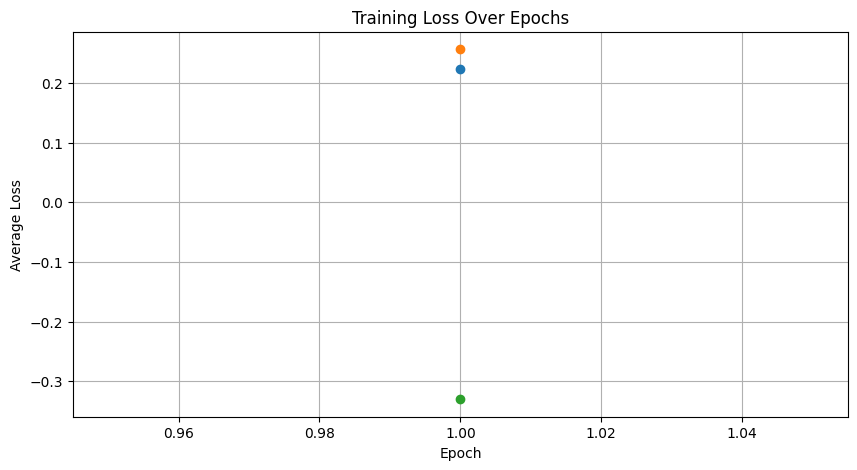

In [ ]:
autoencoder_trainer = MeshAutoencoderTrainer(model = autoencoder ,warmup_steps = 10, dataset = dataset, num_train_steps=100,
                                            batch_size=8,
                                            grad_accum_every=2,
                                            learning_rate = 4e-3)
if is_train_autoencoder:
  if is_train_autoencoder_iteration:
    autoencoder_trainer.load(f'{working_dir}/mesh-encoder_{project_name}.pt')
  loss = autoencoder_trainer.train(380,stop_at_loss = 0.28, diplay_graph= True)
  autoencoder_trainer.save(f'{working_dir}/mesh-encoder_{project_name}.pt')
else:
  autoencoder_trainer.load(f'{working_dir}/mesh-encoder_{project_name}.pt')
  autencoder = autoencoder_trainer.model
  for param in autoencoder.parameters():
      param.requires_grad = True
  import gc

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

max_length =  max(len(d["faces"]) for d in dataset if "faces" in d)
max_seq = max_length * 6
print("Highest face count:" , max_length)
print("Max token sequence:" , max_seq)

transformer = MeshTransformer(
    autoencoder,
    dim = 512,
    coarse_pre_gateloop_depth = 6, # Better performance using more gateloop layers
    fine_pre_gateloop_depth= 4,
    #attn_depth = 24, # GPT-2 medium have 24 layer depth, change if needed
    max_seq_len = max_seq,
    condition_on_text = True,
    gateloop_use_heinsen = False,
    text_condition_model_types = "bge", ## Change or remove this line if you are using:  https://github.com/MarcusLoppe/classifier-free-guidance-pytorch
    text_condition_cond_drop_prob = 0.0
)

total_params = sum(p.numel() for p in transformer.decoder.parameters())
total_params = f"{total_params / 1000000:.1f}M"
print(f"Decoder total parameters: {total_params}")
total_params = sum(p.numel() for p in transformer.parameters())
total_params = f"{total_params / 1000000:.1f}M"
print(f"Total parameters: {total_params}")

Highest face count: 4447
Max token sequence: 26682


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Decoder total parameters: 94.4M
Total parameters: 154.3M


## **Required!**, embed the text and run generate_codes to save 4-96 GB VRAM (dependant on dataset) ##

**If you don't;** <br>
During each during each training step the autoencoder will generate the codes and the text encoder will embed the text.
<br>
After these fields are generate: **they will be deleted and next time it generates the code again:**<br>

This is due to the dataloaders nature, it writes this information to a temporary COPY of the dataset


In [ ]:
labels = set(item["texts"] for item in dataset.data)
print(labels)
dataset.embed_texts(transformer)
dataset.generate_codes(autoencoder)
print(dataset.data[0].keys())

{'S Door Double', 'S Primitive Wedge', 'S Table Sit Square', 'S Chair Modern', 'S Table Counter', 'S Table Office', 'S Primitive Cylinder Hollow', 'S Door Single', 'S Table Nightstand', 'S Table Bar Circle', 'S Chair Stool', 'S Door Double Frame', 'S Door Single Frame', 'S Mask', 'S Bed King', 'Sk Horse 01', 'S Table Coffee', 'S Primitive Pyramid', 'S Bone', 'S Cabinet Dresser 03', 'S Stairs Single-6', 'S Table Bedside', 'Mire Clothing', 'S Primitive Cylinder', 'S Bed Full', 'S Chair Sofa Wide', 'S Cabinet Bookshelf', 'S Tree Bushy', 'S Ziggurat', 'S Table Bar', 'S Chair Stool Mini', 'S Hmd', 'S Phone', 'S Box', 'S Tree No Leaves', 'S Primitive Sphere', 'S Table Bar Rectangle', 'Sk Cat 01', 'S Table Sit Rectangle', 'S Chair Bar', 'S Bed Twin', 'S Chair Sofa', 'Sk Snake 01', 'S Chair Box', 'S Cabinet Dresser 05', 'S Gui', 'S Table Sit Circle'}
[MeshDataset] Generated 47 text_embeddings
[MeshDataset] Generated codes for 423 entrys
dict_keys(['vertices', 'faces', 'face_edges', 'text_embed

*Load previous saved model if you had to restart session*

**Train to about 0.0001 loss (or less) if you are using a small dataset**

In [ ]:
if not is_train_mesh_transformer:
  trainer = MeshTransformerTrainer(model = transformer, warmup_steps = 10,grad_accum_every=1,num_train_steps=100, dataset = dataset, learning_rate = 1e-1, batch_size=1)
  if is_train_mesh_transformer_iteration:
    trainer.load(f'{working_dir}/mesh-transformer_{project_name}.pt')
  transformer = trainer.model
else:
  trainer = MeshTransformerTrainer(model = transformer,warmup_steps = 10,grad_accum_every=4,num_train_steps=100, dataset = dataset,
                                 learning_rate = 5e-4, batch_size=2)
  loss = trainer.train(200, stop_at_loss = 0.00001)

Epoch 1/200: 100%|██████████| 211/211 [01:58<00:00,  1.79it/s, loss=8.39]


Epoch 1 average loss: 9.074482623999717


Epoch 2/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=7.48]


Epoch 2 average loss: 7.88637790860723


Epoch 3/200: 100%|██████████| 211/211 [01:55<00:00,  1.82it/s, loss=6.87]


Epoch 3 average loss: 7.082348733151694


Epoch 4/200: 100%|██████████| 211/211 [01:57<00:00,  1.80it/s, loss=6.12]


Epoch 4 average loss: 6.486401998601254          avg loss speed: 1.5280010899849596


Epoch 5/200: 100%|██████████| 211/211 [01:57<00:00,  1.79it/s, loss=5.71]


Epoch 5 average loss: 6.0004782993081625          avg loss speed: 1.151231247478564


Epoch 6/200: 100%|██████████| 211/211 [02:01<00:00,  1.74it/s, loss=5.53]


Epoch 6 average loss: 5.620637932094917          avg loss speed: 0.9024384115921196


Epoch 7/200: 100%|██████████| 211/211 [02:00<00:00,  1.76it/s, loss=5.02]


Epoch 7 average loss: 5.3080258742327935          avg loss speed: 0.7278135357686502


Epoch 8/200: 100%|██████████| 211/211 [01:57<00:00,  1.80it/s, loss=5.14]


Epoch 8 average loss: 5.026195781490814          avg loss speed: 0.6168515870544766


Epoch 9/200: 100%|██████████| 211/211 [01:56<00:00,  1.81it/s, loss=4.73]


Epoch 9 average loss: 4.724442596119162          avg loss speed: 0.5938439331536802


Epoch 10/200: 100%|██████████| 211/211 [03:00<00:00,  1.17it/s, loss=4.35]


Epoch 10 average loss: 4.462186563636454          avg loss speed: 0.5573681869778015


Epoch 11/200: 100%|██████████| 211/211 [03:12<00:00,  1.10it/s, loss=3.88]


Epoch 11 average loss: 4.200638033202474          avg loss speed: 0.5369702805463357


Epoch 12/200: 100%|██████████| 211/211 [03:19<00:00,  1.06it/s, loss=3.3]


Epoch 12 average loss: 3.9309089144259266          avg loss speed: 0.5315134832267692


Epoch 13/200: 100%|██████████| 211/211 [02:06<00:00,  1.66it/s, loss=3.03]


Epoch 13 average loss: 3.6449290191957737          avg loss speed: 0.5529821512258448


Epoch 14/200: 100%|██████████| 211/211 [01:57<00:00,  1.80it/s, loss=4.13]


Epoch 14 average loss: 3.356792721703154          avg loss speed: 0.5686992672382374


Epoch 15/200: 100%|██████████| 211/211 [01:57<00:00,  1.79it/s, loss=2.87]


Epoch 15 average loss: 3.1394932371745177          avg loss speed: 0.5047169812671006


Epoch 16/200: 100%|██████████| 211/211 [01:57<00:00,  1.80it/s, loss=3.02]


Epoch 16 average loss: 2.907397612011263          avg loss speed: 0.4730073806798858


Epoch 17/200: 100%|██████████| 211/211 [01:56<00:00,  1.81it/s, loss=2.9]


Epoch 17 average loss: 2.619536259445534          avg loss speed: 0.5150249308507777


Epoch 18/200: 100%|██████████| 211/211 [01:57<00:00,  1.80it/s, loss=2.28]


Epoch 18 average loss: 2.403667932155573          avg loss speed: 0.48514110405486477


Epoch 19/200: 100%|██████████| 211/211 [01:57<00:00,  1.80it/s, loss=3.08]


Epoch 19 average loss: 2.135194015728919          avg loss speed: 0.508339918808538


Epoch 20/200: 100%|██████████| 211/211 [01:57<00:00,  1.79it/s, loss=2.5]


Epoch 20 average loss: 1.9386974270874855          avg loss speed: 0.44743530868919


Epoch 21/200: 100%|██████████| 211/211 [01:54<00:00,  1.85it/s, loss=2.13]


Epoch 21 average loss: 1.712147763696327          avg loss speed: 0.44703869462766566


Epoch 22/200: 100%|██████████| 211/211 [02:01<00:00,  1.74it/s, loss=2.37]


Epoch 22 average loss: 1.5759311703285335          avg loss speed: 0.3527485651757103


Epoch 23/200: 100%|██████████| 211/211 [01:57<00:00,  1.80it/s, loss=1.44]


Epoch 23 average loss: 1.3419031904771994          avg loss speed: 0.400355596560249


Epoch 24/200: 100%|██████████| 211/211 [02:00<00:00,  1.76it/s, loss=0.726]


Epoch 24 average loss: 1.2237231465877514          avg loss speed: 0.3196042282462688


Epoch 25/200: 100%|██████████| 211/211 [01:57<00:00,  1.80it/s, loss=0.324]


Epoch 25 average loss: 1.0345804584676055          avg loss speed: 0.34593871066355586


Epoch 26/200: 100%|██████████| 211/211 [01:57<00:00,  1.80it/s, loss=1.11]


Epoch 26 average loss: 0.895188447211591          avg loss speed: 0.30488048463259454


Epoch 27/200: 100%|██████████| 211/211 [01:57<00:00,  1.79it/s, loss=0.266]


Epoch 27 average loss: 0.7992366136744689          avg loss speed: 0.25192740374784695


Epoch 28/200: 100%|██████████| 211/211 [01:57<00:00,  1.79it/s, loss=1.3]


Epoch 28 average loss: 0.6646199077544337          avg loss speed: 0.24504859869678808


Epoch 29/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.537]


Epoch 29 average loss: 0.5737719007401387          avg loss speed: 0.2125764221400258


Epoch 30/200: 100%|██████████| 211/211 [01:55<00:00,  1.82it/s, loss=0.8]


Epoch 30 average loss: 0.45421038838147554          avg loss speed: 0.2249990856748716


Epoch 31/200: 100%|██████████| 211/211 [01:54<00:00,  1.85it/s, loss=0.0583]


Epoch 31 average loss: 0.36526484409638493          avg loss speed: 0.19893588819563102 epochs left: 0.33


Epoch 32/200: 100%|██████████| 211/211 [01:56<00:00,  1.81it/s, loss=0.32]


Epoch 32 average loss: 0.3143778439275744          avg loss speed: 0.1500378671450921 epochs left: 0.10


Epoch 33/200: 100%|██████████| 211/211 [01:56<00:00,  1.81it/s, loss=0.0516]


Epoch 33 average loss: 0.24729975838196502          avg loss speed: 0.13065126708651328 epochs left: 0.40


Epoch 34/200: 100%|██████████| 211/211 [01:57<00:00,  1.79it/s, loss=0.0542]


Epoch 34 average loss: 0.20140717126499702          avg loss speed: 0.10757364420364446 epochs left: 0.92


Epoch 35/200: 100%|██████████| 211/211 [01:57<00:00,  1.79it/s, loss=0.457]


Epoch 35 average loss: 0.1592843101417284          avg loss speed: 0.0950772810497838 epochs left: 1.48


Epoch 36/200: 100%|██████████| 211/211 [01:56<00:00,  1.82it/s, loss=0.0601]


Epoch 36 average loss: 0.12667490872091028          avg loss speed: 0.07598883787531985 epochs left: 2.28


Epoch 37/200: 100%|██████████| 211/211 [01:56<00:00,  1.81it/s, loss=0.335]


Epoch 37 average loss: 0.0980246240158358          avg loss speed: 0.06443083936004278 epochs left: 3.13


Epoch 38/200: 100%|██████████| 211/211 [01:57<00:00,  1.80it/s, loss=0.216]


Epoch 38 average loss: 0.07326423850404849          avg loss speed: 0.054730375788776306 epochs left: 4.14


Epoch 39/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.0385]


Epoch 39 average loss: 0.05556687894078651          avg loss speed: 0.04375437813947835 epochs left: 5.59


Epoch 40/200: 100%|██████████| 211/211 [01:56<00:00,  1.82it/s, loss=0.112]


Epoch 40 average loss: 0.0402469188681146          avg loss speed: 0.03537166161877567 epochs left: 7.34


Epoch 41/200: 100%|██████████| 211/211 [01:55<00:00,  1.83it/s, loss=0.00748]


Epoch 41 average loss: 0.029079500162064748          avg loss speed: 0.027279845275585118 epochs left: 9.93


Epoch 42/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.02]


Epoch 42 average loss: 0.024493825599833687          avg loss speed: 0.0171372737238216 epochs left: 16.08


Epoch 43/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.00639]


Epoch 43 average loss: 0.022633041155864418          avg loss speed: 0.008640373720806595 epochs left: 32.10


Epoch 44/200: 100%|██████████| 211/211 [01:57<00:00,  1.80it/s, loss=0.0175]


Epoch 44 average loss: 0.01828024458246067          avg loss speed: 0.007121877723460283 epochs left: 39.56


Epoch 45/200: 100%|██████████| 211/211 [01:54<00:00,  1.84it/s, loss=0.00739]


Epoch 45 average loss: 0.020492539685925744          avg loss speed: 0.0013098307601271779 epochs left: 213.39


Epoch 46/200: 100%|██████████| 211/211 [01:59<00:00,  1.77it/s, loss=0.0119]


Epoch 46 average loss: 0.014428926600911324          avg loss speed: 0.0060396818738389525 epochs left: 47.28


Epoch 47/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.00423]


Epoch 47 average loss: 0.009133709154325709          avg loss speed: 0.008600194468773536 epochs left: 33.82


Epoch 48/200: 100%|██████████| 211/211 [01:55<00:00,  1.83it/s, loss=0.00562]


Epoch 48 average loss: 0.007495466826077533          avg loss speed: 0.007189591654310059 epochs left: 40.68


Epoch 49/200: 100%|██████████| 211/211 [01:51<00:00,  1.89it/s, loss=0.00576]


Epoch 49 average loss: 0.009815638838556564          avg loss speed: 0.0005370620218816229 epochs left: 540.32


Epoch 50/200: 100%|██████████| 211/211 [01:56<00:00,  1.82it/s, loss=0.0242]


Epoch 50 average loss: 0.012365427938559185          avg loss speed: -0.0035504896655725836


Epoch 51/200: 100%|██████████| 211/211 [01:56<00:00,  1.82it/s, loss=0.0123]


Epoch 51 average loss: 0.008235214430379783          avg loss speed: 0.0016569634373513123 epochs left: 176.08


Epoch 52/200: 100%|██████████| 211/211 [01:57<00:00,  1.79it/s, loss=0.00319]


Epoch 52 average loss: 0.0053112280126925895          avg loss speed: 0.004827532389805921 epochs left: 61.04


Epoch 53/200: 100%|██████████| 211/211 [01:56<00:00,  1.81it/s, loss=0.00212]


Epoch 53 average loss: 0.004280638091500089          avg loss speed: 0.004356652035710429 epochs left: 67.88


Epoch 54/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.00194]


Epoch 54 average loss: 0.003921735711214773          avg loss speed: 0.0020206244669760476 epochs left: 146.53


Epoch 55/200: 100%|██████████| 211/211 [01:59<00:00,  1.77it/s, loss=0.00232]


Epoch 55 average loss: 0.0035744265397189634          avg loss speed: 0.0009301073987501877 epochs left: 318.70


Epoch 56/200: 100%|██████████| 211/211 [01:56<00:00,  1.81it/s, loss=0.00181]


Epoch 56 average loss: 0.003371186352498229          avg loss speed: 0.0005544137616463793 epochs left: 535.03


Epoch 57/200: 100%|██████████| 211/211 [01:52<00:00,  1.87it/s, loss=0.00189]


Epoch 57 average loss: 0.003789799616195403          avg loss speed: -0.00016735008171808122


Epoch 58/200: 100%|██████████| 211/211 [01:57<00:00,  1.80it/s, loss=0.00149]


Epoch 58 average loss: 0.003973982214676084          avg loss speed: -0.00039551137853855193


Epoch 59/200: 100%|██████████| 211/211 [01:55<00:00,  1.82it/s, loss=0.00157]


Epoch 59 average loss: 0.002900056460413252          avg loss speed: 0.000811599600709987 epochs left: 366.07


Epoch 60/200: 100%|██████████| 211/211 [01:57<00:00,  1.80it/s, loss=0.00144]


Epoch 60 average loss: 0.0026727983875915197          avg loss speed: 0.0008818143761700602 epochs left: 337.18


Epoch 61/200: 100%|██████████| 211/211 [01:56<00:00,  1.80it/s, loss=0.00256]


Epoch 61 average loss: 0.0028899565429572386          avg loss speed: 0.00029232247793637995 epochs left: 1016.38


Epoch 62/200: 100%|██████████| 211/211 [01:56<00:00,  1.81it/s, loss=0.00604]


Epoch 62 average loss: 0.01932817040688813          avg loss speed: -0.01650723327656746


Epoch 63/200: 100%|██████████| 211/211 [01:56<00:00,  1.81it/s, loss=0.00531]


Epoch 63 average loss: 0.011951528494003542          avg loss speed: -0.003654553381524579


Epoch 64/200: 100%|██████████| 211/211 [01:56<00:00,  1.81it/s, loss=0.00349]


Epoch 64 average loss: 0.004733575080406644          avg loss speed: 0.0066563100675429915 epochs left: 44.36


Epoch 65/200: 100%|██████████| 211/211 [01:57<00:00,  1.80it/s, loss=0.00219]


Epoch 65 average loss: 0.0037438296415000026          avg loss speed: 0.00826059501893277 epochs left: 35.86


Epoch 66/200: 100%|██████████| 211/211 [01:57<00:00,  1.80it/s, loss=0.00129]


Epoch 66 average loss: 0.003222047647028738          avg loss speed: 0.003587596758274658 epochs left: 82.72


Epoch 67/200: 100%|██████████| 211/211 [01:55<00:00,  1.82it/s, loss=0.00105]


Epoch 67 average loss: 0.0027508123530079367          avg loss speed: 0.0011490051033038583 epochs left: 258.70


Epoch 68/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.001]


Epoch 68 average loss: 0.002579746348838547          avg loss speed: 0.0006591501983403453 epochs left: 451.22


Epoch 69/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.00644]


Epoch 69 average loss: 0.002994415065840822          avg loss speed: -0.000143546282882415


Epoch 70/200: 100%|██████████| 211/211 [01:56<00:00,  1.82it/s, loss=0.0012]


Epoch 70 average loss: 0.0031368894175895583          avg loss speed: -0.0003618981616937897


Epoch 71/200: 100%|██████████| 211/211 [01:52<00:00,  1.87it/s, loss=0.000653]


Epoch 71 average loss: 0.002823629919980251          avg loss speed: 8.005369077605795e-05 epochs left: 3712.21


Epoch 72/200: 100%|██████████| 211/211 [01:59<00:00,  1.77it/s, loss=0.000648]


Epoch 72 average loss: 0.0028614783510609895          avg loss speed: 0.00012349978340922118 epochs left: 2405.98


Epoch 73/200: 100%|██████████| 211/211 [01:55<00:00,  1.83it/s, loss=0.00426]


Epoch 73 average loss: 0.002792513084054982          avg loss speed: 0.00014815281215528435 epochs left: 2006.09


Epoch 74/200: 100%|██████████| 211/211 [01:56<00:00,  1.81it/s, loss=0.00199]


Epoch 74 average loss: 0.0028334500667279348          avg loss speed: -7.576281695860672e-06


Epoch 75/200: 100%|██████████| 211/211 [01:55<00:00,  1.83it/s, loss=0.000476]


Epoch 75 average loss: 0.0025470669206697494          avg loss speed: 0.0002820802466115529 epochs left: 1054.50


Epoch 76/200: 100%|██████████| 211/211 [01:58<00:00,  1.79it/s, loss=0.00211]


Epoch 76 average loss: 0.002416769846759613          avg loss speed: 0.0003075735103912759 epochs left: 967.52


Epoch 77/200: 100%|██████████| 211/211 [01:55<00:00,  1.82it/s, loss=0.000488]


Epoch 77 average loss: 0.0026215713685521884          avg loss speed: -2.247575716642254e-05


Epoch 78/200: 100%|██████████| 211/211 [01:56<00:00,  1.81it/s, loss=0.00235]


Epoch 78 average loss: 0.0023348153938740155          avg loss speed: 0.00019365398478650127 epochs left: 1537.10


Epoch 79/200: 100%|██████████| 211/211 [01:59<00:00,  1.77it/s, loss=0.000928]


Epoch 79 average loss: 0.0021652063601473744          avg loss speed: 0.00029251250958123136 epochs left: 1018.20


Epoch 80/200: 100%|██████████| 211/211 [02:00<00:00,  1.75it/s, loss=0.000702]


Epoch 80 average loss: 0.0022854194754317525          avg loss speed: 8.844489875944059e-05 epochs left: 3366.10


Epoch 81/200: 100%|██████████| 211/211 [01:57<00:00,  1.80it/s, loss=0.00546]


Epoch 81 average loss: 0.013315169624151149          avg loss speed: -0.011053355881000102


Epoch 82/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.0029]


Epoch 82 average loss: 0.009633403081641095          avg loss speed: -0.0037114712617310032


Epoch 83/200: 100%|██████████| 211/211 [01:58<00:00,  1.77it/s, loss=0.00217]


Epoch 83 average loss: 0.005994277093691919          avg loss speed: 0.002417053633382747 epochs left: 121.64


Epoch 84/200: 100%|██████████| 211/211 [01:57<00:00,  1.80it/s, loss=0.00221]


Epoch 84 average loss: 0.003614627144860007          avg loss speed: 0.006032989454968048 epochs left: 49.13


Epoch 85/200: 100%|██████████| 211/211 [01:55<00:00,  1.82it/s, loss=0.00273]


Epoch 85 average loss: 0.002284313013591755          avg loss speed: 0.004129789426472586 epochs left: 72.09


Epoch 86/200: 100%|██████████| 211/211 [01:56<00:00,  1.80it/s, loss=0.000623]


Epoch 86 average loss: 0.002660250158261031          avg loss speed: 0.0013041555924535298 epochs left: 227.99


Epoch 87/200: 100%|██████████| 211/211 [01:59<00:00,  1.77it/s, loss=0.000704]


Epoch 87 average loss: 0.0026112177761788017          avg loss speed: 0.0002418456627254627 epochs left: 1229.66


Epoch 88/200: 100%|██████████| 211/211 [01:55<00:00,  1.83it/s, loss=0.000616]


Epoch 88 average loss: 0.0027538734729295835          avg loss speed: -0.00023527982358572102


Epoch 89/200: 100%|██████████| 211/211 [01:55<00:00,  1.82it/s, loss=0.000445]


Epoch 89 average loss: 0.002121309289913978          avg loss speed: 0.0005538045125424943 epochs left: 537.88


Epoch 90/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.000639]


Epoch 90 average loss: 0.0025943929095856265          avg loss speed: -9.892606324483867e-05


Epoch 91/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.0011]


Epoch 91 average loss: 0.002788217308472012          avg loss speed: -0.00029835875099561626


Epoch 92/200: 100%|██████████| 211/211 [01:56<00:00,  1.81it/s, loss=0.00163]


Epoch 92 average loss: 0.0029707420798034023          avg loss speed: -0.00046943557714619654


Epoch 93/200: 100%|██████████| 211/211 [01:55<00:00,  1.83it/s, loss=0.000748]


Epoch 93 average loss: 0.0022632291771403088          avg loss speed: 0.0005212215888133714 epochs left: 571.23


Epoch 94/200: 100%|██████████| 211/211 [01:57<00:00,  1.79it/s, loss=0.0123]


Epoch 94 average loss: 0.002658663379906796          avg loss speed: 1.539947523177855e-05 epochs left: 19308.54


Epoch 95/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.000889]


Epoch 95 average loss: 0.0025365977431923343          avg loss speed: 9.428046909116822e-05 epochs left: 3155.09


Epoch 96/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.000438]


Epoch 96 average loss: 0.0023265318176488425          avg loss speed: 0.00015963161576430405 epochs left: 1864.75


Epoch 97/200: 100%|██████████| 211/211 [01:58<00:00,  1.77it/s, loss=0.000808]


Epoch 97 average loss: 0.002585247275557466          avg loss speed: -7.798296197480828e-05


Epoch 98/200: 100%|██████████| 211/211 [01:58<00:00,  1.79it/s, loss=0.002]


Epoch 98 average loss: 0.002114500714299353          avg loss speed: 0.0003682915645001946 epochs left: 808.83


Epoch 99/200: 100%|██████████| 211/211 [01:56<00:00,  1.82it/s, loss=0.0019]


Epoch 99 average loss: 0.0025107151080006776          avg loss speed: -0.00016862183883212386


Epoch 100/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.000392]


Epoch 100 average loss: 0.0024539945998573367          avg loss speed: -5.05069005715046e-05


Epoch 101/200: 100%|██████████| 211/211 [01:56<00:00,  1.81it/s, loss=0.000963]


Epoch 101 average loss: 0.002248256836666933          avg loss speed: 0.00011147997071885626 epochs left: 2670.90


Epoch 102/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.0012]


Epoch 102 average loss: 0.002794917637285869          avg loss speed: -0.0003905954557775534


Epoch 103/200: 100%|██████████| 211/211 [02:00<00:00,  1.75it/s, loss=0.00244]


Epoch 103 average loss: 0.0026612746797146725          avg loss speed: -0.00016221832177795974


Epoch 104/200: 100%|██████████| 211/211 [01:56<00:00,  1.81it/s, loss=0.0806]


Epoch 104 average loss: 0.006760316988082505          avg loss speed: -0.004192167270193347


Epoch 105/200: 100%|██████████| 211/211 [01:56<00:00,  1.81it/s, loss=0.00525]


Epoch 105 average loss: 0.01593605887643569          avg loss speed: -0.011863889108074677


Epoch 106/200: 100%|██████████| 211/211 [01:57<00:00,  1.79it/s, loss=0.00542]


Epoch 106 average loss: 0.006549857909928001          avg loss speed: 0.001902692271482956 epochs left: 154.23


Epoch 107/200: 100%|██████████| 211/211 [01:57<00:00,  1.80it/s, loss=0.00181]


Epoch 107 average loss: 0.0036346293744185312          avg loss speed: 0.006114115217063535 epochs left: 48.47


Epoch 108/200: 100%|██████████| 211/211 [01:57<00:00,  1.79it/s, loss=0.000929]


Epoch 108 average loss: 0.0027802848214089374          avg loss speed: 0.005926563898851804 epochs left: 50.15


Epoch 109/200: 100%|██████████| 211/211 [01:55<00:00,  1.83it/s, loss=0.00323]


Epoch 109 average loss: 0.0027564882289207765          avg loss speed: 0.0015651024729977131 epochs left: 189.92


Epoch 110/200: 100%|██████████| 211/211 [01:55<00:00,  1.83it/s, loss=0.00249]


Epoch 110 average loss: 0.0022043560255568264          avg loss speed: 0.0008527781160259222 epochs left: 349.21


Epoch 111/200: 100%|██████████| 211/211 [02:00<00:00,  1.75it/s, loss=0.00107]


Epoch 111 average loss: 0.002214827259199173          avg loss speed: 0.0003655490994296743 epochs left: 814.62


Epoch 112/200: 100%|██████████| 211/211 [01:56<00:00,  1.81it/s, loss=0.00331]


Epoch 112 average loss: 0.0022087688767461556          avg loss speed: 0.00018312162781276972 epochs left: 1626.19


Epoch 113/200: 100%|██████████| 211/211 [02:00<00:00,  1.75it/s, loss=0.00203]


Epoch 113 average loss: 0.0019369128724875731          avg loss speed: 0.00027240451467981197 epochs left: 1094.19


Epoch 114/200: 100%|██████████| 211/211 [01:57<00:00,  1.80it/s, loss=0.00101]


Epoch 114 average loss: 0.002444568280212281          avg loss speed: -0.00032439861073464736


Epoch 115/200: 100%|██████████| 211/211 [01:59<00:00,  1.76it/s, loss=0.00188]


Epoch 115 average loss: 0.0021752913116137563          avg loss speed: 2.145869820158056e-05 epochs left: 13878.97


Epoch 116/200: 100%|██████████| 211/211 [01:57<00:00,  1.80it/s, loss=0.000695]


Epoch 116 average loss: 0.00227577044251728          avg loss speed: -9.017962107940982e-05


Epoch 117/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.0313]


Epoch 117 average loss: 0.0024151977142528743          avg loss speed: -0.00011665436947176817


Epoch 118/200: 100%|██████████| 211/211 [01:57<00:00,  1.80it/s, loss=0.000762]


Epoch 118 average loss: 0.0021212331909836396          avg loss speed: 0.00016751996514433086 epochs left: 1778.17


Epoch 119/200: 100%|██████████| 211/211 [01:55<00:00,  1.83it/s, loss=0.000711]


Epoch 119 average loss: 0.0027029193213355166          avg loss speed: -0.00043218553875091874


Epoch 120/200: 100%|██████████| 211/211 [01:53<00:00,  1.86it/s, loss=0.000411]


Epoch 120 average loss: 0.0028890318308142566          avg loss speed: -0.00047591508862357976


Epoch 121/200: 100%|██████████| 211/211 [01:58<00:00,  1.79it/s, loss=0.000414]


Epoch 121 average loss: 0.002370531909373011          avg loss speed: 0.00020052953833812632 epochs left: 1484.22


Epoch 122/200: 100%|██████████| 211/211 [01:57<00:00,  1.79it/s, loss=0.00392]


Epoch 122 average loss: 0.002760070554307393          avg loss speed: -0.00010590953379979815


Epoch 123/200: 100%|██████████| 211/211 [01:57<00:00,  1.79it/s, loss=0.000807]


Epoch 123 average loss: 0.0023298238636374085          avg loss speed: 0.0003433875678608119 epochs left: 866.86


Epoch 124/200: 100%|██████████| 211/211 [01:57<00:00,  1.79it/s, loss=0.000565]


Epoch 124 average loss: 0.002751811778683754          avg loss speed: -0.0002650030029111498


Epoch 125/200: 100%|██████████| 211/211 [02:00<00:00,  1.75it/s, loss=0.000404]


Epoch 125 average loss: 0.0025153073757529366          avg loss speed: 9.859468978991532e-05 epochs left: 3017.25


Epoch 126/200: 100%|██████████| 211/211 [01:57<00:00,  1.80it/s, loss=0.00192]


Epoch 126 average loss: 0.0022332167039929903          avg loss speed: 0.00029909763536504303 epochs left: 995.55


Epoch 127/200: 100%|██████████| 211/211 [01:56<00:00,  1.81it/s, loss=0.000332]


Epoch 127 average loss: 0.00228611895496189          avg loss speed: 0.00021399299784800353 epochs left: 1391.23


Epoch 128/200: 100%|██████████| 211/211 [01:59<00:00,  1.77it/s, loss=0.00271]


Epoch 128 average loss: 0.002367561480573321          avg loss speed: -2.2680469004048454e-05


Epoch 129/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.000485]


Epoch 129 average loss: 0.0021578710801679842          avg loss speed: 0.00013776129967474956 epochs left: 2162.02


Epoch 130/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.0141]


Epoch 130 average loss: 0.01132662995606418          avg loss speed: -0.009056112784163116


Epoch 131/200: 100%|██████████| 211/211 [01:55<00:00,  1.83it/s, loss=0.0166]


Epoch 131 average loss: 0.004525933570285897          avg loss speed: 0.0007580872686492653 epochs left: 389.76


Epoch 132/200: 100%|██████████| 211/211 [01:56<00:00,  1.81it/s, loss=0.00232]


Epoch 132 average loss: 0.002815999534539437          avg loss speed: 0.00318747866763325 epochs left: 93.23


Epoch 133/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.000494]


Epoch 133 average loss: 0.0028232928103120707          avg loss speed: 0.0033995615433177672 epochs left: 87.42


Epoch 134/200: 100%|██████████| 211/211 [01:54<00:00,  1.84it/s, loss=0.00539]


Epoch 134 average loss: 0.0024229136921280017          avg loss speed: 0.0009654949462511333 epochs left: 308.21


Epoch 135/200: 100%|██████████| 211/211 [01:59<00:00,  1.77it/s, loss=0.00138]


Epoch 135 average loss: 0.0021419141138683106          avg loss speed: 0.0005454878984581923 epochs left: 546.04


Epoch 136/200: 100%|██████████| 211/211 [01:59<00:00,  1.76it/s, loss=0.000441]


Epoch 136 average loss: 0.002730095054749046          avg loss speed: -0.00026738818264625177


Epoch 137/200: 100%|██████████| 211/211 [01:57<00:00,  1.80it/s, loss=0.000739]


Epoch 137 average loss: 0.002323690732064882          avg loss speed: 0.00010795022151690366 epochs left: 2757.53


Epoch 138/200: 100%|██████████| 211/211 [01:57<00:00,  1.80it/s, loss=0.000745]


Epoch 138 average loss: 0.0025117696557796485          avg loss speed: -0.00011320302221890215


Epoch 139/200: 100%|██████████| 211/211 [01:55<00:00,  1.83it/s, loss=0.00974]


Epoch 139 average loss: 0.0021792654617318785          avg loss speed: 0.0003425863524659802 epochs left: 869.33


Epoch 140/200: 100%|██████████| 211/211 [01:58<00:00,  1.79it/s, loss=0.000389]


Epoch 140 average loss: 0.002441786429199271          avg loss speed: -0.00010354447934046804


Epoch 141/200: 100%|██████████| 211/211 [01:56<00:00,  1.81it/s, loss=0.00289]


Epoch 141 average loss: 0.0024497541753460447          avg loss speed: -7.214699310911224e-05


Epoch 142/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.00727]


Epoch 142 average loss: 0.002658307684891111          avg loss speed: -0.00030137232946537973


Epoch 143/200: 100%|██████████| 211/211 [01:57<00:00,  1.80it/s, loss=0.000923]


Epoch 143 average loss: 0.002526640126087716          avg loss speed: -1.0024029608906877e-05


Epoch 144/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.000969]


Epoch 144 average loss: 0.0023949139961703587          avg loss speed: 0.00014998666593793192 epochs left: 1984.21


Epoch 145/200: 100%|██████████| 211/211 [01:56<00:00,  1.81it/s, loss=0.000711]


Epoch 145 average loss: 0.002035381359608747          avg loss speed: 0.0004912392427743151 epochs left: 606.56


Epoch 146/200: 100%|██████████| 211/211 [01:54<00:00,  1.85it/s, loss=0.000936]


Epoch 146 average loss: 0.00281507335644617          avg loss speed: -0.0004960948624905628


Epoch 147/200: 100%|██████████| 211/211 [01:59<00:00,  1.76it/s, loss=0.00165]


Epoch 147 average loss: 0.002654386568296992          avg loss speed: -0.00023926366422190011


Epoch 148/200: 100%|██████████| 211/211 [01:56<00:00,  1.81it/s, loss=0.00214]


Epoch 148 average loss: 0.0022702253389423844          avg loss speed: 0.00023138842250825182 epochs left: 1286.71


Epoch 149/200: 100%|██████████| 211/211 [01:59<00:00,  1.77it/s, loss=0.000643]


Epoch 149 average loss: 0.002563616754823713          avg loss speed: 1.6278333071469055e-05 epochs left: 18271.92


Epoch 150/200: 100%|██████████| 211/211 [01:57<00:00,  1.79it/s, loss=0.000799]


Epoch 150 average loss: 0.00220854452793802          avg loss speed: 0.0002875316927496768 epochs left: 1035.68


Epoch 151/200: 100%|██████████| 211/211 [01:56<00:00,  1.81it/s, loss=0.000458]


Epoch 151 average loss: 0.0030321216532658186          avg loss speed: -0.0006846594460311133


Epoch 152/200: 100%|██████████| 211/211 [01:59<00:00,  1.76it/s, loss=0.00137]


Epoch 152 average loss: 0.0025862663921125463          avg loss speed: 1.5161253229970927e-05 epochs left: 19616.70


Epoch 153/200: 100%|██████████| 211/211 [02:00<00:00,  1.75it/s, loss=0.00129]


Epoch 153 average loss: 0.002361600047669272          avg loss speed: 0.00024737747676952275 epochs left: 1203.18


Epoch 154/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.000615]


Epoch 154 average loss: 0.002045700583944618          avg loss speed: 0.0006142954470712606 epochs left: 485.03


Epoch 155/200: 100%|██████████| 211/211 [01:56<00:00,  1.81it/s, loss=0.0038]


Epoch 155 average loss: 0.009993542062854658          avg loss speed: -0.007662353054945847


Epoch 156/200: 100%|██████████| 211/211 [01:59<00:00,  1.76it/s, loss=0.00346]


Epoch 156 average loss: 0.005350975929406335          avg loss speed: -0.0005506950312501521


Epoch 157/200: 100%|██████████| 211/211 [01:55<00:00,  1.82it/s, loss=0.00186]


Epoch 157 average loss: 0.0032328381576912997          avg loss speed: 0.0025639013677105703 epochs left: 115.75


Epoch 158/200: 100%|██████████| 211/211 [01:59<00:00,  1.77it/s, loss=0.000797]


Epoch 158 average loss: 0.002374628783309594          avg loss speed: 0.003817823266674504 epochs left: 77.96


Epoch 159/200: 100%|██████████| 211/211 [01:55<00:00,  1.83it/s, loss=0.00327]


Epoch 159 average loss: 0.002507088746449588          avg loss speed: 0.001145725543686155 epochs left: 259.65


Epoch 160/200: 100%|██████████| 211/211 [01:54<00:00,  1.85it/s, loss=0.000879]


Epoch 160 average loss: 0.0022706791959367515          avg loss speed: 0.00043417269988007537 epochs left: 685.74


Epoch 161/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.000451]


Epoch 161 average loss: 0.0028479098767468097          avg loss speed: -0.0004637776348481652


Epoch 162/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.000396]


Epoch 162 average loss: 0.0022966064747491346          avg loss speed: 0.0002452861316285817 epochs left: 1213.70


Epoch 163/200: 100%|██████████| 211/211 [01:59<00:00,  1.76it/s, loss=0.000438]


Epoch 163 average loss: 0.0028318192937270125          avg loss speed: -0.00036008744458278057


Epoch 164/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.00117]


Epoch 164 average loss: 0.0024718899181624654          avg loss speed: 0.0001868886302451864 epochs left: 1592.01


Epoch 165/200: 100%|██████████| 211/211 [01:57<00:00,  1.79it/s, loss=0.00248]


Epoch 165 average loss: 0.002486503411302899          avg loss speed: 4.6935150909971704e-05 epochs left: 6338.82


Epoch 166/200: 100%|██████████| 211/211 [01:57<00:00,  1.79it/s, loss=0.00105]


Epoch 166 average loss: 0.002058534516750998          avg loss speed: 0.0005382030243131276 epochs left: 553.59


Epoch 167/200: 100%|██████████| 211/211 [01:57<00:00,  1.79it/s, loss=0.002]


Epoch 167 average loss: 0.0022453466083819126          avg loss speed: 9.362934035687508e-05 epochs left: 3180.14


Epoch 168/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.00147]


Epoch 168 average loss: 0.0025113135208243336          avg loss speed: -0.00024785200867906334


Epoch 169/200: 100%|██████████| 211/211 [01:56<00:00,  1.82it/s, loss=0.0248]


Epoch 169 average loss: 0.002587058894795264          avg loss speed: -0.0003153273461428494


Epoch 170/200: 100%|██████████| 211/211 [02:01<00:00,  1.74it/s, loss=0.000383]


Epoch 170 average loss: 0.0021375465984467277          avg loss speed: 0.00031035974288710867 epochs left: 959.73


Epoch 171/200: 100%|██████████| 211/211 [01:55<00:00,  1.83it/s, loss=0.000602]


Epoch 171 average loss: 0.002067922832586657          avg loss speed: 0.0003440501721021184 epochs left: 865.96


Epoch 172/200: 100%|██████████| 211/211 [01:57<00:00,  1.79it/s, loss=0.000724]


Epoch 172 average loss: 0.002210607377578332          avg loss speed: 5.3568731031217696e-05 epochs left: 5559.02


Epoch 173/200: 100%|██████████| 211/211 [01:55<00:00,  1.83it/s, loss=0.00419]


Epoch 173 average loss: 0.0020787459536084807          avg loss speed: 5.994631592875794e-05 epochs left: 4969.80


Epoch 174/200: 100%|██████████| 211/211 [02:01<00:00,  1.74it/s, loss=0.00238]


Epoch 174 average loss: 0.0019147663528399797          avg loss speed: 0.00020432570175117648 epochs left: 1458.87


Epoch 175/200: 100%|██████████| 211/211 [01:58<00:00,  1.78it/s, loss=0.0185]


Epoch 175 average loss: 0.001972562643937696          avg loss speed: 9.547725073790186e-05 epochs left: 3121.45


Epoch 176/200: 100%|██████████| 211/211 [01:55<00:00,  1.83it/s, loss=0.00105]


Epoch 176 average loss: 0.002280600413666835          avg loss speed: -0.000291908763538116


Epoch 177/200: 100%|██████████| 211/211 [01:55<00:00,  1.82it/s, loss=0.00517]


Epoch 177 average loss: 0.0022805767437008373          avg loss speed: -0.0002246002735526672


Epoch 178/200:  30%|███       | 64/211 [00:33<00:51,  2.85it/s, loss=0.00202]

**Load the latest model**

In [ ]:
autoencoder_trainer = MeshAutoencoderTrainer(model = autoencoder ,warmup_steps = 10, dataset = dataset, num_train_steps=100, batch_size=8,  grad_accum_every=1, learning_rate = 1e-4)
autoencoder_trainer.load(f'{working_dir}/mesh-encoder_{project_name}.pt')
autencoder = autoencoder_trainer.model
for param in autoencoder.parameters():
    param.requires_grad = True
import gc
torch.cuda.empty_cache()
gc.collect()

max_length =  max(len(d["faces"]) for d in dataset if "faces" in d)
max_seq = max_length * 6
print("Highest face count:" , max_length)
print("Max token sequence:" , max_seq)

transformer = MeshTransformer(
    autoencoder,
    dim = 512,
    coarse_pre_gateloop_depth = 6, # Better performance using more gateloop layers
    fine_pre_gateloop_depth= 4,
    # attn_depth = 24, # GPT-2 medium have 24 layer depth, change if needed
    max_seq_len = max_seq,
    condition_on_text = True,
    gateloop_use_heinsen = False,
    text_condition_model_types = "bge", ## Change or remove this line if you are using:  https://github.com/MarcusLoppe/classifier-free-guidance-pytorch
    text_condition_cond_drop_prob = 0.0
).to("cuda")

trainer = MeshTransformerTrainer(model = transformer,warmup_steps = 10,grad_accum_every=1,num_train_steps=100, dataset = dataset, learning_rate = 1e-1, batch_size=2)
trainer.load(f'{working_dir}/mesh-transformer_{project_name}.pt')
transformer = trainer.model


## Generate and view mesh

In [ ]:
trainer.save(f'{working_dir}/mesh-transformer_{project_name}.pt')

In [ ]:
def combind_mesh(path, mesh):
    all_vertices = []
    all_faces = []
    vertex_offset = 0
    translation_distance = 0.5

    for r, faces_coordinates in enumerate(mesh):
        numpy_data = faces_coordinates[0].cpu().numpy().reshape(-1, 3)

        for vertex in numpy_data:
            all_vertices.append(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")

        for i in range(1, len(numpy_data), 3):
            all_faces.append(f"f {i + vertex_offset} {i + 1 + vertex_offset} {i + 2 + vertex_offset}\n")

        vertex_offset += len(numpy_data)

    obj_file_content = "".join(all_vertices) + "".join(all_faces)

    with open(path , "w") as file:
        file.write(obj_file_content)

def combind_mesh_with_rows(path, meshes):
    all_vertices = []
    all_faces = []
    vertex_offset = 0
    translation_distance = 0.5

    for row, mesh in enumerate(meshes):
        for r, faces_coordinates in enumerate(mesh):
            numpy_data = faces_coordinates[0].cpu().numpy().reshape(-1, 3)
            numpy_data[:, 0] += translation_distance * (r / 0.2 - 1)
            numpy_data[:, 2] += translation_distance * (row / 0.2 - 1)

            for vertex in numpy_data:
                all_vertices.append(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")

            for i in range(1, len(numpy_data), 3):
                all_faces.append(f"f {i + vertex_offset} {i + 1 + vertex_offset} {i + 2 + vertex_offset}\n")

            vertex_offset += len(numpy_data)

        obj_file_content = "".join(all_vertices) + "".join(all_faces)

    with open(path , "w") as file:
        file.write(obj_file_content)


def write_mesh_output(path, coords):
    numpy_data = faces_coordinates[0].cpu().numpy().reshape(-1, 3)
    obj_file_content = ""

    for vertex in numpy_data:
        obj_file_content += f"v {vertex[0]} {vertex[1]} {vertex[2]}\n"

    for i in range(1, len(numpy_data), 3):
        obj_file_content += f"f {i} {i + 1} {i + 2}\n"

    with open(path, "w") as file:
        file.write(obj_file_content)


**Using only text**

In [ ]:

from pathlib import Path

folder = working_dir / 'renders'
obj_file_path = Path(folder)
obj_file_path.mkdir(exist_ok = True, parents = True)

text_coords = []
for text in labels:
    print(f"Generating {text}")
    faces_coordinates = transformer.generate(texts = [text],  temperature = 0.0)
    text_coords.append(faces_coordinates)

    write_mesh_output(f'{folder}/3d_output_{text}.obj', faces_coordinates)


combind_mesh(f'{folder}/3d_models_all.obj', text_coords)

**Text + prompt of tokens**

Grab fresh copy of dataset

In [ ]:
dataset = MeshDataset.load(dataset_path)
dataset.generate_codes(autoencoder)

**Prompt with 10% of codes/tokens**

In [ ]:
from pathlib import Path
token_length_procent = 0.10
codes = []
texts = []
for label in labels:
    for item in dataset.data:
        if item['texts'] == label:
            num_tokens = int(item["codes"].shape[0] * token_length_procent)

            texts.append(item['texts'])
            codes.append(item["codes"].flatten()[:num_tokens].unsqueeze(0))
            break

folder = working_dir / f'renders/text+codes'
obj_file_path = Path(folder)
obj_file_path.mkdir(exist_ok = True, parents = True)

coords = []



for text, prompt in zip(texts, codes):
    print(f"Generating {text} with {prompt.shape[1]} tokens")
    faces_coordinates = transformer.generate(texts = [text],  prompt = prompt, temperature = 0)
    coords.append(faces_coordinates)

    obj_file_path = f'{folder}/{text}_{prompt.shape[1]}_tokens.obj'
    write_mesh_output(obj_file_path, faces_coordinates)

    print(obj_file_path)


combind_mesh(f'{folder}/text+prompt_all.obj', coords)

if text_coords is not None:
    combind_mesh_with_rows(f'{folder}/both_verisons.obj', [text_coords , coords])

**Prompt with 0% to 80% of tokens**

In [ ]:
import json
import numpy as np
import trimesh
from pathlib import Path

def convert_to_obj(vertices, faces, output_file_path):
    scene = trimesh.Scene()
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
    scene.add_geometry(mesh)

    with open(output_file_path, "w") as f:
        f.write(scene.export(file_type="obj"))

def encode_to_pua(codes):
    flat_codes = [item for sublist in codes for subsublist in sublist for item in subsublist]
    return "".join(chr(code + 0xF0000) for code in flat_codes)

jsonl_lines = []

for token_length_procent in np.arange(0, 0.8, 0.1):
    codes = []
    texts = []
    for label in labels:
        for item in dataset.data:
            if item['texts'] == label:
                num_tokens = int(item["codes"].shape[0] * token_length_procent)

                texts.append(item['texts'])
                codes.append(item["codes"].flatten()[:num_tokens].unsqueeze(0))
                break

    coords = []
    for text, code in zip(texts, codes):
        print(f"Generating {text} with {code.shape[1]} tokens")
        faces_coordinates = transformer.generate(texts=[text], prompt=code, temperature=0)
        coords.append(faces_coordinates)

        # Process mesh data inlined here
        continuous_coors_list = [np_array.tolist() for np_array in faces_coordinates]
        flat_list = [item for sublist in continuous_coors_list for item in sublist]
        vertices = [vertex for sublist in flat_list for vertex in sublist]
        faces = [[i, i + 1, i + 2] for i in range(0, len(vertices), 3)]

        obj_filename = f'{text}_{code.shape[1]}_tokens.obj'
        obj_file_path = folder / obj_filename
        convert_to_obj(vertices, faces, obj_file_path)

        encoded_codes = encode_to_pua(code.cpu().tolist())

        with open(obj_file_path, "r") as file:
            obj_contents = file.read()

        # Append line to JSONL structure
        jsonl_line = [
            {"role": "system", "content": "This assistant can understand 3D models using the meshgpt-pytorch Unicode plane 15 codebook for 16384 triangles and the .obj 3d format."},
            {"role": "user", "content": encoded_codes},
            {"role": "assistant", "content": obj_contents}
        ]
        jsonl_lines.append(jsonl_line)

        print(obj_file_path)

    mesh_rows.append(coords)
    combind_mesh(f'{folder}/text+prompt_all_{token_length_procent}.obj', coords)

combind_mesh_with_rows(f'{folder}/all.obj', mesh_rows)

with open("chatml.jsonl", "w", encoding="utf-8") as f:
    for item in jsonl_lines:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")